# Sample Size Experiment using Random Forest and Deep Networks

### Random Forest (RF) vs. Deep Networks (DN)

Random forest is inherently a non-parametric model, meaning that the algorithm requires no assumptions about the data distribution. With infinitely many trees and n -> $\infty$, RF will follow non-parametric behavior and will guarantee convergence.

Deep Networks with a fixed architecture are entirely parametric. As presented by [Vogelstein, et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.29.068460v1), there is a clear bias variance tradeoff between DNs as the number of parameters change. This is evident by testing each model over a range of sample sizes. DNs (CNNs) perform particularly well on image datasets. 

### Experiment Discription

In [Vogelstein, et al. (2020)](https://www.biorxiv.org/content/10.1101/2020.04.29.068460v1), when trained on the CIFAR-10 dataset, both a simple DN and an overparametrized DN produced a lower classification error than RF for sample sizes greater than 2500. RF outperformed both DNs for sample sizes smaller than 2500. While this experiment only tests up to 10000 sample sizes, RF is theoretically guaranteed to produce a lower classification error at infinite samples due to its non-parametric nature.

The goal of this tutorial is to identify a joint distribution (X,Y) that demonstrates this relationship. RF should profuce a smaller generalization error as small sample sizes, a specific parametric DN should produce a smaller generalization error at medium sample sizes, and RF should once again produce a smaller generalization error at large sample sizes.

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

### Load dependencies

Import required dependencies and model functions from sample_size_experiment.py

In [2]:
from sample_size_experiment import *

<IPython.core.display.Javascript object>

In [62]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from IPython.display import display
from scipy import stats

from sklearn.metrics import accuracy_score
from tensorflow.keras.utils import to_categorical

<IPython.core.display.Javascript object>

### Randomly sample subset of points

Function takes in X and y data. Randomly select a desired number of indices and outputs the data in those positions.

In [4]:
from random import sample


def random_sample(X, y, samples):

    ordered_indices = [num for num in range(samples)]
    random_indices = sample(ordered_indices, samples)

    X = X[random_indices]
    y = y[random_indices]

    return X, y

<IPython.core.display.Javascript object>

### Testing suite

Testing function. Creates a DNN and a RF model based on the function attributes. Fits the models to the inputted data. Reruns model over a range of sample sizes for X, y data stored in the attribute sample_sizes. Reruns the entire testing suite for an inputted number of iterations to average out classification error.

In [5]:
from sklearn.model_selection import train_test_split


def test_suite(
    X,
    y,
    iterations,
    output_nodes,
    sample_sizes=[500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000],
    num_trees=100,
    max_depth=None,
    rf_verbose=1,
    epochs=10,
    batch_size=50,
    learning_rate=0.001,
    validation_split=0.3,
    dnn_verbose=1,
):

    X = np.array(X, dtype=np.float32)
    y = np.array(y, dtype=np.float32)

    rf_evolution = np.zeros((len(sample_sizes), iterations))
    dnn_evolution = np.zeros((len(sample_sizes), iterations))

    for iteration in range(iterations):
        print("iteration: ", iteration)

        for sample_size_index, max_sample_size in enumerate(sample_sizes):
            print("Max sample size: ", max_sample_size)

            X_scaled, y_scaled = random_sample(X, y, max_sample_size)
            X_train, X_test, y_train, y_test = train_test_split(
                X_scaled, y_scaled, test_size=0.3, random_state=101
            )

            rf_model = random_forest_classifier_model(
                X_train=X_train,
                y_train=y_train,
                num_trees=num_trees,
                max_depth=max_depth,
                verbose=rf_verbose,
            )

            rf_predictions = rf_model.predict(X_test)
            rf_error = 1 - accuracy_score(y_test, rf_predictions)

            rf_evolution[sample_size_index][iteration] = rf_error

            if output_nodes == 1:
                dnn_model = binary_deep_neural_network(
                    X_train=X_train,
                    y_train=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    validation_split=validation_split,
                    verbose=dnn_verbose,
                )
            else:
                y_train = to_categorical(y_train, num_classes=output_nodes)
                y_test = to_categorical(y_test, num_classes=output_nodes)

                dnn_model = multiclass_deep_neural_network(
                    X_train=X_train,
                    y_train=y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    learning_rate=learning_rate,
                    validation_split=validation_split,
                    output_nodes=output_nodes,
                    verbose=dnn_verbose,
                )

            score = dnn_model.evaluate(
                X_test,
                y_test,
                batch_size=None,
                verbose=0,
                sample_weight=None,
                steps=None,
                callbacks=None,
                max_queue_size=10,
                workers=1,
                use_multiprocessing=False,
                return_dict=False,
            )

            dnn_error = 1 - score[1]
            dnn_evolution[sample_size_index][iteration] = dnn_error

    return rf_evolution, dnn_evolution

<IPython.core.display.Javascript object>

## Sparse Parity Dataset

Sparse parity is a binary classification dataset. It can be thought of as a multivariate generalization of the noisy XOR problem. Creating the dataset requires two parameters: p, the total number of dimensions of the data, and p_star, the number of dimensions within the data that contain useful information about the class label (p_star < p)

In [6]:
X_parity = np.random.uniform(-1, 1, [35000, 14])

<IPython.core.display.Javascript object>

In [7]:
def sparse_parity_labels(X, p_star):
    q = np.zeros(X.shape[0])
    y = np.where(X[:, :3] >= 0, 1, 0)
    return np.sum(y, axis=1) % 2

<IPython.core.display.Javascript object>

In [8]:
y_parity = sparse_parity_labels(X_parity, 3)

<IPython.core.display.Javascript object>

In [9]:
np.array(X_parity, dtype=np.float32).shape

(35000, 14)

<IPython.core.display.Javascript object>

In [ ]:
sample_sizes = [
    500,
    1000,
    2000,
    3000,
    5000,
    7000,
    10000,
    12500,
    15000,
    20000,
    25000,
    30000,
    35000,
]

rf_evolution_parity, dnn_evolution_parity = test_suite(
    X_parity,
    y_parity,
    iterations=20,
    output_nodes=1,
    sample_sizes=sample_sizes,
    num_trees=500,
    rf_verbose=1,
    batch_size=8,
)

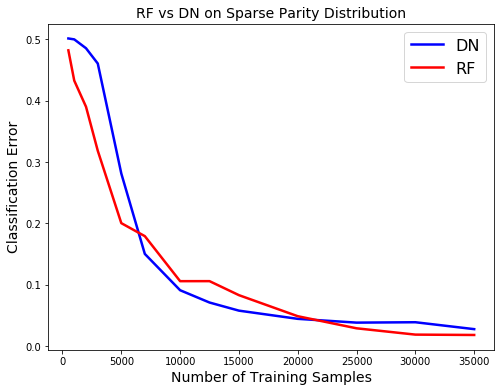

<IPython.core.display.Javascript object>

In [11]:
dnn_evolution_mean = np.mean(dnn_evolution_parity, axis=1)
rf_evolution_mean = np.mean(rf_evolution_parity, axis=1)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.plot(sample_sizes, dnn_evolution_mean, "b", linewidth=2.5)
ax.plot(sample_sizes, rf_evolution_mean, "r", linewidth=2.5)
plt.title("RF vs DN on Sparse Parity Distribution", fontsize=14)
plt.xlabel("Number of Training Samples", fontsize=14)
plt.ylabel("Classification Error", fontsize=14)
plt.legend(["DN", "RF"], prop={"size": 16})

fig.savefig("sparse_parity_p14_3_ss35000_DN_14_8_1_RF_100_trs_20_iters_8_bs.png")

In [13]:
dnn_parity_20_iters_14_3 = dnn_evolution_parity
rf_parity_20_iters_14_3 = rf_evolution_parity

<IPython.core.display.Javascript object>

In [15]:
%store dnn_parity_20_iters_14_3
%store rf_parity_20_iters_14_3

Stored 'dnn_parity_20_iters_14_3' (ndarray)
Stored 'rf_parity_20_iters_14_3' (ndarray)


<IPython.core.display.Javascript object>

In [63]:
print("DNN accuracies\n\n", dnn_parity_20_iters_14_3)
print("\nRF accuracies\n\n", rf_parity_20_iters_14_3)

DNN accuracies

 [[0.59999999 0.50666666 0.48000002 0.45333332 0.53333333 0.44
  0.50666666 0.59333333 0.45333332 0.46666664 0.61333334 0.44666666
  0.49333334 0.58000001 0.45333332 0.49333334 0.48000002 0.50666666
  0.49333334 0.43333334]
 [0.49666667 0.46333331 0.48666668 0.51666668 0.53333333 0.5
  0.51333332 0.45666665 0.50333333 0.52000001 0.49000001 0.48000002
  0.53666666 0.53666666 0.51666668 0.50666666 0.48000002 0.47000003
  0.56       0.43000001]
 [0.48500001 0.49000001 0.48333335 0.48666668 0.50666666 0.495
  0.47666669 0.48666668 0.51333332 0.45166665 0.45666665 0.50166667
  0.45333332 0.49833333 0.54333332 0.47500002 0.50333333 0.45499998
  0.48500001 0.46166664]
 [0.4577778  0.49555558 0.44666666 0.45666665 0.5        0.44222224
  0.43666667 0.46777779 0.44777775 0.46555555 0.35555553 0.46111113
  0.49222225 0.48000002 0.45444447 0.46222222 0.45888889 0.4911111
  0.45222223 0.48555553]
 [0.37599999 0.19400001 0.18533331 0.31400001 0.296      0.26533335
  0.27200001 0.102

<IPython.core.display.Javascript object>

In [64]:
yerr_dn = stats.sem(dnn_parity_20_iters_14_3, axis=1)
yerr_rf = stats.sem(rf_parity_20_iters_14_3, axis=1)

<IPython.core.display.Javascript object>

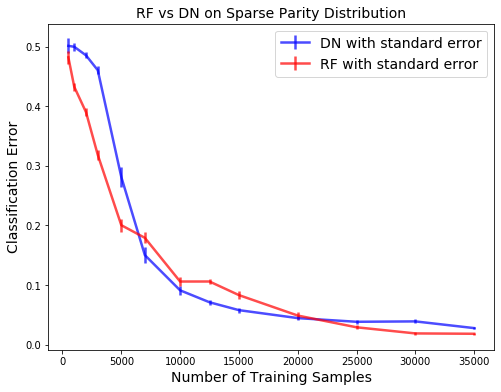

<IPython.core.display.Javascript object>

In [66]:
dnn_evolution_mean = np.mean(dnn_parity_20_iters_14_3, axis=1)
rf_evolution_mean = np.mean(rf_parity_20_iters_14_3, axis=1)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.errorbar(
    sample_sizes, dnn_evolution_mean, yerr=yerr_dn, linewidth=2.5, c="b", alpha=0.7
)
ax.errorbar(
    sample_sizes, rf_evolution_mean, yerr=yerr_rf, linewidth=2.5, c="r", alpha=0.7
)
plt.title("RF vs DN on Sparse Parity Distribution", fontsize=14)
plt.xlabel("Number of Training Samples", fontsize=14)
plt.ylabel("Classification Error", fontsize=14)
plt.legend(["DN with standard error", "RF with standard error"], prop={"size": 14})

fig.savefig("sparse_parity_p14_3_ss35000_DN_14_8_1_RF_100_trs_20_iters_8_bs_eb.png")

In [ ]:
X_parity = np.random.uniform(-1, 1, [35000, 14])
def sparse_parity_labels(X, p_star):
    q = np.zeros(X.shape[0])
    y = np.where(X[:, :3] >= 0, 1, 0)
    return np.sum(y, axis=1) % 2

In [ ]:
# Test code for visualizing only rf evolution

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

sample_sizes = [500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 30000]
num_trees = 100
max_depth = None
verbose = 2

X_parity = np.array(X_parity, dtype=np.float32)
y_parity = np.array(y_parity, dtype=np.float32)

rf_evolution = np.zeros((len(sample_sizes), 5))

for iteration in range(5):
    print("iteration: ", iteration)

    for sample_size_index, max_sample_size in enumerate(sample_sizes):
        print("Max sample size: ", max_sample_size)

        X_scaled, y_scaled = random_sample(X_parity, y_parity, max_sample_size)
        X_train, X_test, y_train, y_test = train_test_split(
            X_scaled, y_scaled, test_size=0.3, random_state=101
        )

        rf_model = RandomForestClassifier(
            n_estimators=num_trees, max_depth=max_depth, verbose=verbose
        )
        rf_model.fit(X_train, y_train)

        rf_predictions = rf_model.predict(X_test)
        rf_error = 1 - accuracy_score(y_test, rf_predictions)

        rf_evolution[sample_size_index][iteration] = rf_error

rf_evolution

In [ ]:
rf_evolution_mean = np.mean(rf_evolution, axis=1)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(111)
ax.plot(sample_sizes, rf_evolution_mean, "r", linewidth=2.5)
plt.title("RF on Sparse Parity Distribution", fontsize=14)
plt.xlabel("Number of Training Samples", fontsize=14)
plt.ylabel("Classification Error", fontsize=14)
